# LinearSimulator Tutorial

In this tutorial, we use the `LinearSimulator` class to simulate cryo-EM particles obtained from various maps:

|specimen|EMDB|published map resolution|PDB|
|-|-|-|-|
|Ryanodine receptor|https://www.ebi.ac.uk/emdb/EMD-22015|3.8|https://www.rcsb.org/structure/6X32|
|Ptch1 and ShhN complex|https://www.ebi.ac.uk/emdb/EMD-7968|3.6|https://www.rcsb.org/structure/6dmy|


In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt, axes as ax
import mrcfile

from simSPI.linear_simulator.linear_simulator import LinearSimulator
from tests.test_linear_simulator import init_data

# Helper function to visualise the volume
def plot_mip(vol, axis=0):
    """Maximum intensity projection along the specified axis."""
    plt.imshow(np.max(vol, axis=axis))
    plt.colorbar()

The `LinearSimulator` class implements the so-called "weak-phase approximation" of the cryo-EM image formation model as a linear operator, which we will use to generate particle images from a volume. First, we load the ground truth volume to visualise it in the notebook. 

To do this, set the `root_dir` variable to the local simSPI installation.

In [3]:
root_dir = "/Users/gw/repos/helena-fork/simSPI/"  # change this to your simSPI directory.
vol_path = f"{root_dir}/tests/data/micelle/6dmy_molmap-3.6A-zeropad136.mrc"
data_path = f"{root_dir}/tests/data/linear_simulator_data.npy"

In [4]:
with mrcfile.open(vol_path) as file:
    vol = file.data

vol.shape

(136, 136, 136)

In [5]:
# import torch.nn.functional as F

# def zero_pad_cube(vol):
#     nx,ny,nz = vol.shape
#     n_max = max(nx,ny,nz)
#     padx = (n_max - nx)//2
#     pady = (n_max - ny)//2
#     padz = (n_max - nz)//2
#     print(padx,pady,padz)
#     return F.pad(vol,(padz,padz,pady,pady,padx,padx),mode='constant', value=0)
    

# vol_pad = zero_pad_cube(torch.from_numpy(vol)).numpy()

# import mrcfile
# mrcfile.write(f"{root_dir}/tests/data/micelle/6dmy_molmap-3.6A-zeropad136.mrc", vol_pad)

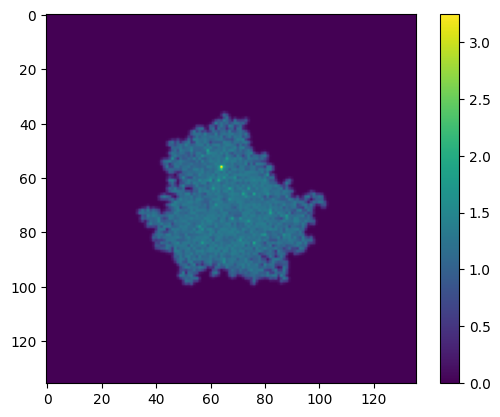

In [6]:
plot_mip(vol)

First, we load some example data from the tests directory, by calling `init_data` in `test_linear_simulator`.

In [7]:
saved_data, config = init_data(data_path)
config

{'chunks': 4,
 'pixel_size': 0.8,
 'cs': 2.7,
 'amplitude_contrast': 0.1,
 'ctf_size': 32,
 'noise': False,
 'noise_sigma': 0,
 'noise_distribution': 'gaussian',
 'input_volume_path': '',
 'side_len': 32,
 'kv': 300,
 'value_nyquist': 0.1,
 'b_factor': 0}

In [8]:
config['b_factor'] = 10

To initialise a `LinearSimulator` object, we need to provide it with parameters that are common accross all particle images. These are passed to the `LinearSimulator` constructor using the `config` dictionary. First, we update some entries in `config` with information specific to the volume we loaded above.

In [9]:
nx = vol.shape[0]

config["input_volume_path"] = vol_path
config["side_len"] = nx
config["ctf_size"] = nx
config["pixel_size"] = 1.2

And we also need to set `noise` and `noise_sigma` to the desired values depending on the required amount.

In [10]:
config["noise"] = True
config["noise_sigma"] = 1.0

config

{'chunks': 4,
 'pixel_size': 1.2,
 'cs': 2.7,
 'amplitude_contrast': 0.1,
 'ctf_size': 136,
 'noise': True,
 'noise_sigma': 1.0,
 'noise_distribution': 'gaussian',
 'input_volume_path': '/Users/gw/repos/helena-fork/simSPI//tests/data/micelle/6dmy_molmap-3.6A-zeropad136.mrc',
 'side_len': 136,
 'kv': 300,
 'value_nyquist': 0.1,
 'b_factor': 10}

In [11]:
type(config)

tests.test_linear_simulator.AttrDict

And we can optionally add in a detergent micelle

In [12]:
config["do_micelle"] = True
scale = 1.2
config["micelle_scale_factor"] = 100000
config["micelle_axis_a"] = 64 // scale
config["micelle_axis_b"] = 64 // scale
config["micelle_axis_c"] = 24 // scale
config["micelle_radius_cavity"] = 24 // scale
config["micelle_inner_shell_ratio"] = 0.9
config["micelle_shell_density_ratio"] = 1
config["micelle_box_size"] = nx
config["micelle_translation_x"] = 2.5
config["micelle_translation_y"] = -2.5
config["micelle_translation_z"] = -35.0

config

{'chunks': 4,
 'pixel_size': 1.2,
 'cs': 2.7,
 'amplitude_contrast': 0.1,
 'ctf_size': 136,
 'noise': True,
 'noise_sigma': 1.0,
 'noise_distribution': 'gaussian',
 'input_volume_path': '/Users/gw/repos/helena-fork/simSPI//tests/data/micelle/6dmy_molmap-3.6A-zeropad136.mrc',
 'side_len': 136,
 'kv': 300,
 'value_nyquist': 0.1,
 'b_factor': 10,
 'do_micelle': True,
 'micelle_scale_factor': 100000,
 'micelle_axis_a': 53.0,
 'micelle_axis_b': 53.0,
 'micelle_axis_c': 20.0,
 'micelle_radius_cavity': 20.0,
 'micelle_inner_shell_ratio': 0.9,
 'micelle_shell_density_ratio': 1,
 'micelle_box_size': 136,
 'micelle_translation_x': 2.5,
 'micelle_translation_y': -2.5,
 'micelle_translation_z': -35.0}

Now we are ready to initalise the `LinearSimulator`:

In [13]:
lin_sim = LinearSimulator(config)
lin_sim

LinearSimulator(
  (projector): Projector()
  (ctf): CTF()
  (shift): Shift()
  (micelle): Micelle(
    (micelle_shift): Shift()
  )
  (noise): Noise()
)

Given the `LinearSimulator` instance above, we generate particle images with the rotation, shift, and CTF parameters passed as dictionaries. Here, we use the rotations, shifts and CTF parameters loaded from the test data in the `saved_data` dictionary.

In [14]:
rot_params = saved_data["rot_params"]
ctf_params = saved_data["ctf_params"]
shift_params = saved_data["shift_params"]

In [15]:
ctf_params['defocus_u'] = ctf_params['defocus_u']
ctf_params['defocus_v'] = ctf_params['defocus_v']

And the actual particle generation:

In [16]:
particles = lin_sim(rot_params, ctf_params, shift_params, do_micelle=True)

else
else
else
else
else
else
else
else
large shifts result in numerical instabilities from aliasing. consider upsampling


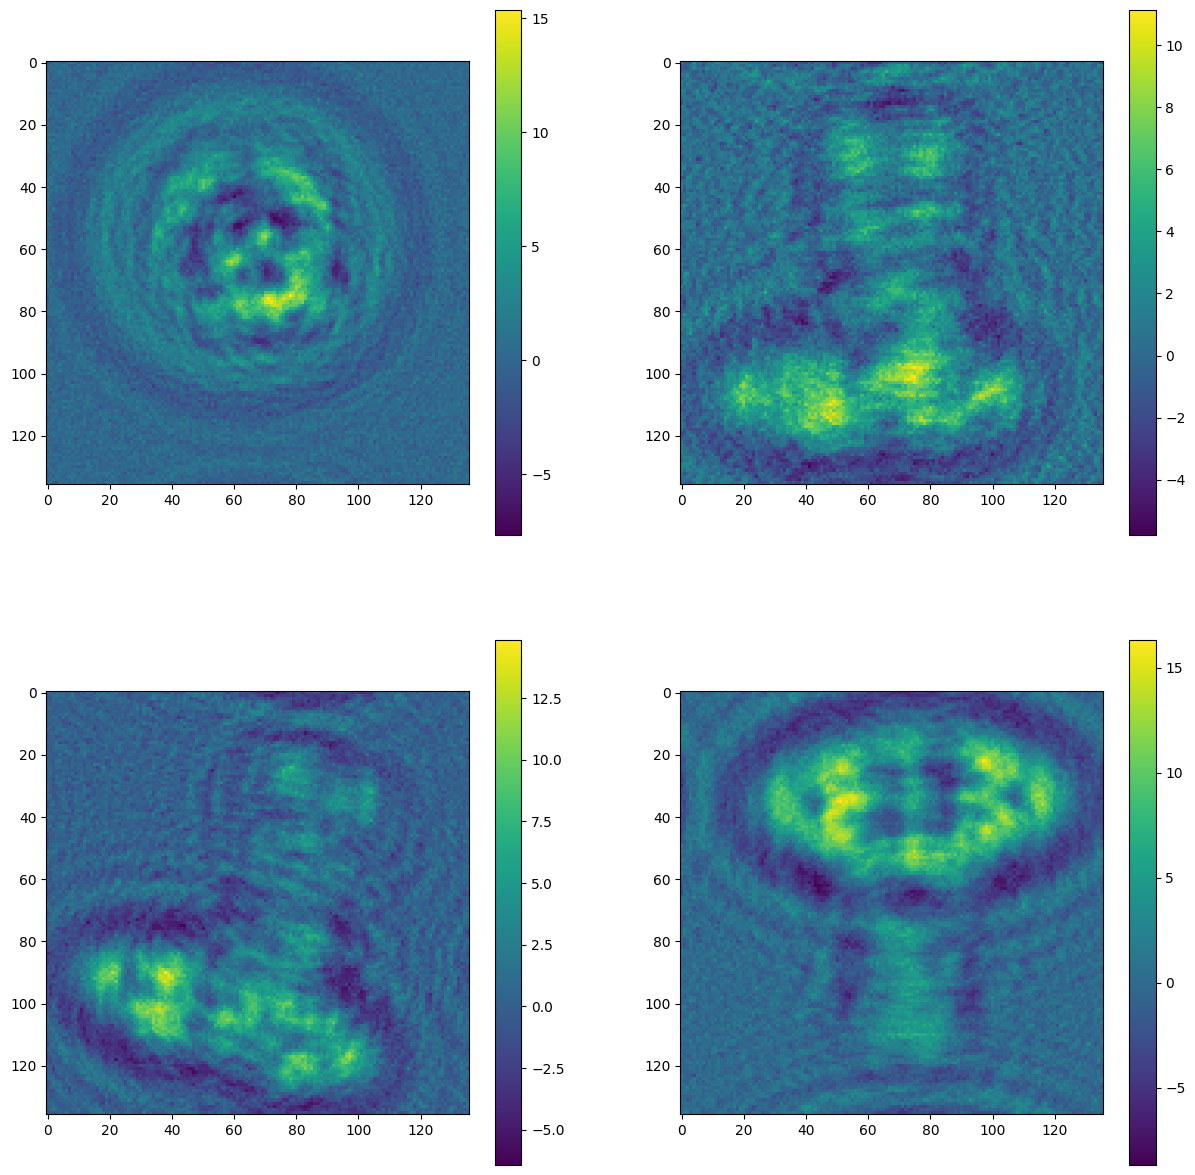

In [17]:
f, ax = plt.subplots(2, 2, figsize=(15, 15))

ax00 = ax[0, 0].imshow(particles[0, 0],interpolation='none') ; f.colorbar(ax00)
ax01 = ax[0, 1].imshow(particles[1, 0],interpolation='none') ; f.colorbar(ax01)
ax10 = ax[1, 0].imshow(particles[2, 0],interpolation='none') ; f.colorbar(ax10)
ax11 = ax[1, 1].imshow(particles[3, 0],interpolation='none') ; f.colorbar(ax11)

# Modelled micelle vs micelle in map
* Consider these maps, which have a strong micelle density:

* The molmap was simulated from the atomic model in Chimera at low resolution, and then compared against the map at this resolution.

* Note the similarities and differences between the modelled and empirical micelle density